In [1]:
import numpy as np
import pandas as pd

In [2]:
#One-hot encoding the tendecy variable(3 categories). and dropping DR 
raw_data=pd.read_csv("../data/cleaned_data.csv")
tendecy_one_hot=pd.get_dummies(raw_data.loc[:,"Tendency"])
raw_data=pd.concat([raw_data,tendecy_one_hot],axis=1)
raw_data.drop(['Tendency','DR'],axis=1, inplace=True)
raw_data.columns

Index(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC',
       'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'Width', 'Min', 'Max',
       'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'NSP',
       'left_assymetric', 'right_symmetric', 'symmetric'],
      dtype='object')

In [3]:
#Normalizing only the continuous variables
continuous_attributes=raw_data.iloc[:,6:26]
categorical_attributes=raw_data.iloc[:,26:]
continuous_attributes=(continuous_attributes-continuous_attributes.min())/(continuous_attributes.max()-continuous_attributes.min())
dataset=pd.concat([continuous_attributes,categorical_attributes.iloc[:,1:],categorical_attributes.iloc[:,0]],axis=1)
dataset.to_csv("../data/cleaned_normalized_data.csv",index=False)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import math

In [5]:
#dividing into train and test data
dataset_array=dataset.values
no_of_instances=len(dataset_array)
split=math.floor(0.7*no_of_instances)
data_x=dataset_array[:,:-1]
data_y=dataset_array[:,-1]
X_train=dataset_array[:split,:-1]
y_train=dataset_array[:split,-1]
X_test=dataset_array[split:,:-1]
y_test=dataset_array[split:,-1]

In [26]:
#Perform grid search to select the best values of C and gamma and the kernel function
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    #Cs = [0.001, 0.01, 0.1, 1, 10]
    #gammas = [0.001, 0.01, 0.1, 1, 10, 100]
    Cs = [i for i in range(1,100)]
    gammas = [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_param_selection(data_x,data_y,5)

{'C': 33, 'gamma': 0.1}

In [11]:
#Define the SVC classifier using sklearn package
classifier = svm.SVC(kernel='rbf', C = 4.0,gamma=2.0, verbose=True)

#Training the model
classifier.fit(X_train,y_train)

#testing the model
y_pred=classifier.predict(X_test)

#getting the classification metrics
confusion_mtx = confusion_matrix(y_test, y_pred) 
print("\nConfusion Matrix=\n",confusion_mtx)
target_names = ['normal', 'suspect', 'pathological']
print(classification_report(y_test, y_pred, target_names=target_names))
print("accuracy= ",(confusion_mtx.diagonal().sum()/confusion_mtx.sum())*100)



[LibSVM]
Confusion Matrix=
 [[463  63   6]
 [  4  12   0]
 [ 23   4  63]]
              precision    recall  f1-score   support

      normal       0.94      0.87      0.91       532
     suspect       0.15      0.75      0.25        16
pathological       0.91      0.70      0.79        90

 avg / total       0.92      0.84      0.87       638

accuracy=  84.3260188088


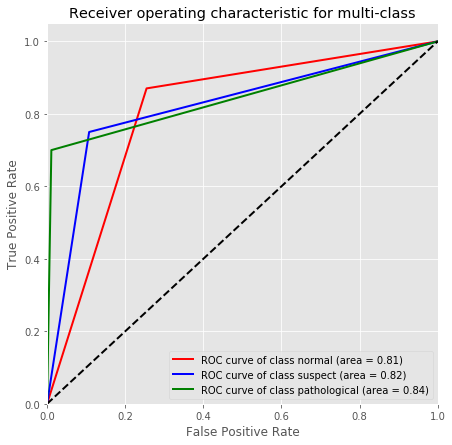

In [16]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

y_actual_binary = label_binarize(y_test, classes=[1, 2, 3])
y_pred_binary = label_binarize(y_pred, classes=[1, 2, 3])
n_classes=3
lw=2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))

colors = cycle(['red','blue','green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()